<a href="https://colab.research.google.com/github/morpheusthewhite/vae-vampprior/blob/main/notebooks/simple_vae.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# A "Hello world" Variational Autoencoder

In [12]:
import tensorflow as tf
import tensorflow_probability as tfp
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras import layers, models

Let's start by loading the MNIST data

In [13]:
mnist = tf.keras.datasets.mnist
(x_train, y_train), (x_test, y_test) = mnist.load_data()

# map to float values
x_train, x_test = x_train / 255.0, x_test / 255.0

In our case the `y` will correspond to the `x` itself. But we need to flatten it.

In [14]:
flattened_size = x_train[0].shape[0] * x_train[0].shape[1]

y_train = np.reshape(x_train, (-1, flattened_size))
y_test = np.reshape(x_test, (-1, flattened_size))

In [15]:
# utility for visualizing the results
import matplotlib.pyplot as plt

def vae_show_results(model, sample):
  plt.figure(figsize=(10, 10))
  
  plt.subplot(1, 2, 1)
  plt.imshow(sample)
  
  # feed data to the autoencoder
  result = model(np.array([sample]))[0]
  
  plt.subplot(1, 2, 2)
  plt.imshow(result)

We can initially try with a very simple model

In [20]:
class Encoder(tf.keras.layers.Layer):
  def __init__(self, K, **kwargs):
    super(Encoder, self).__init__(**kwargs)
    self.K = K

  def build(self, inputs_shape):
    self.flatten = layers.Flatten(input_shape=(inputs_shape[1], inputs_shape[2]),
                                               name='enc-flatten')

    self.dense0 = layers.Dense(300, name='enc-dense0', activation='relu')
    self.dense1 = layers.Dense(300, name='enc-dense1', activation='relu')

    self.dense_mu = layers.Dense(self.K, name='enc-out-mu')
    self.dense_logvar = layers.Dense(self.K, name='enc-out-lo')
    
  def call(self, inputs):
    flattened = self.flatten(inputs)

    x = self.dense0(flattened)
    x = self.dense1(x)

    mu = self.dense_mu(x)
    logvar = self.dense_logvar(x)
    return mu, logvar
  
class Sampling(tf.keras.layers.Layer):
  def __init__(self, K, L, **kwargs):
    super(Sampling, self).__init__(**kwargs)
    self.L = L
    self.K = K
    
    self.normal_standard = tfp.distributions.MultivariateNormalDiag(
                              tf.zeros(shape=(self.K,)), 
                              tf.ones(shape=(self.K,)))

  def call(self, inputs):
    mu, logvar = inputs
    latent_samples = \
        self.normal_standard.sample((self.L, mu.shape[0])) * tf.sqrt(tf.exp(logvar)) + mu
      
    # the returned samples will have shape (N, L, K)
    # where N is the size of the batch
    return tf.reshape(latent_samples, (-1, self.L, self.K))

class Decoder(tf.keras.layers.Layer):
  def __init__(self, output_shape, **kwargs):
    super(Decoder, self).__init__(**kwargs)
    self.output_shape_ = output_shape

    self.dense0 = layers.Dense(300, name='dec-dense0', activation='relu')
    self.dense1 = layers.Dense(300, name='dec-dense1', activation='relu')
    self.reconstruct = layers.Dense(output_shape[0] * output_shape[1], name='dec-out')

  def build(self, inputs_shape):
    # transform the result into a square matrix
    # the result of a single input will be a (L, M, M) tensor
    # where M is the size of the original image
    self.reshape = layers.Reshape((inputs_shape[1],
                                   self.output_shape_[0], self.output_shape_[1]),
                                  name='dec-out-reshaped')

  def call(self, inputs):
    # inputs will have shape (N, L, K)
    x = self.dense0(inputs)
    x = self.dense1(x)

    x = self.reconstruct(x)

    # once reshaped it will have shape (N, L, M, M)
    return self.reshape(x)


# reduce on mean along the L components
class MeanReducer(tf.keras.layers.Layer):
  def __init__(self, **kwargs):
    super(MeanReducer, self).__init__(**kwargs)

  def call(self, inputs):
    # inputs has shape (N, L, M, M)
    # output has shape (N, M, M)
    return tf.reduce_mean(inputs, axis=1)


In [66]:
class VAE(tf.keras.Model):
  def __init__(self, K, L, **kwargs):
    super(VAE, self).__init__(**kwargs)
    self.K = K
    self.L = L

  def build(self, inputs_shape):
    self.encoder = Encoder(self.K)
    self.sampling = Sampling(self.K, self.L)
    self.decoder = Decoder((inputs_shape[1], inputs_shape[2]))
    self.mean_reducer = MeanReducer()
  
  def call(self, inputs):
    mu, logvar = self.encoder(inputs)
    sigma = tf.sqrt(tf.exp(logvar))
    samples = self.sampling((mu, logvar))

    # TODO: improve numerical stability and remove epsilon
    #   to improve decoding performances
    
    # epsilon for avoiding log explosion in loss
    eps = 1e-18                  
    
    # loss due to regularization 
    # first addend, corresponding to log( p_lambda (z_phi^l) )
    normal_standard = tfp.distributions.MultivariateNormalDiag(tf.zeros(self.K), tf.ones(self.K))
    log_p_lambda = tf.math.log(eps + normal_standard.prob(samples))
    
    # second addend, corresponding to log( q_phi (z|x) )
    # where q_phi=N(z| mu_phi(x), sigma^2_phi(x)) 
    normal_latent = tfp.distributions.MultivariateNormalDiag(mu, sigma)
    log_q_phi = tf.math.log(eps + normal_latent.prob(samples))
    
    regularization_loss = tf.math.subtract(tf.math.reduce_mean(log_q_phi),
                                          tf.math.reduce_mean(log_p_lambda),
                                          name='regularization-loss')
    self.add_loss(regularization_loss)

    reconstructed = self.decoder(samples)

    return self.mean_reducer(reconstructed)
    # return reconstructed

  def decode(self, inputs):
    # inputs will have shape (N, K)
    reconstructed = self.decoder(inputs)

    return reconstructed

In [67]:
vae = VAE(40, 1)
vae.compile(optimizer='adam', loss=tf.nn.sigmoid_cross_entropy_with_logits)
vae.fit(x_train, x_train, epochs=4)

Epoch 1/4
1875/1875 [==============================] - 22s 11ms/step - loss: 0.1755
Epoch 2/4
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0970
Epoch 3/4
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0897
Epoch 4/4
1875/1875 [==============================] - 21s 11ms/step - loss: 0.0867


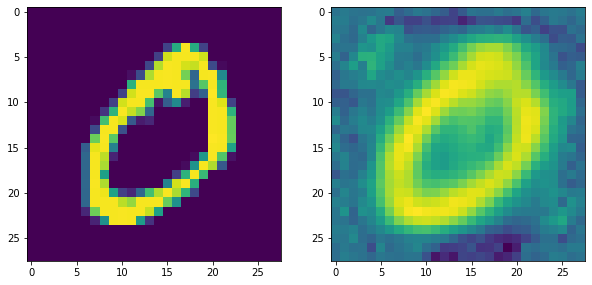

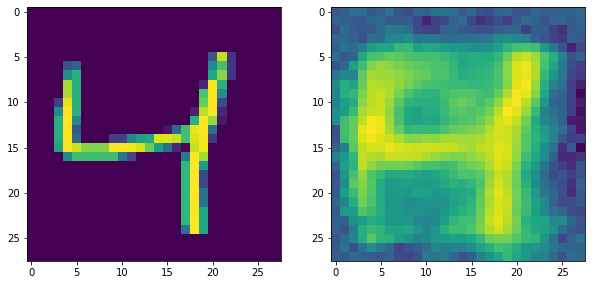

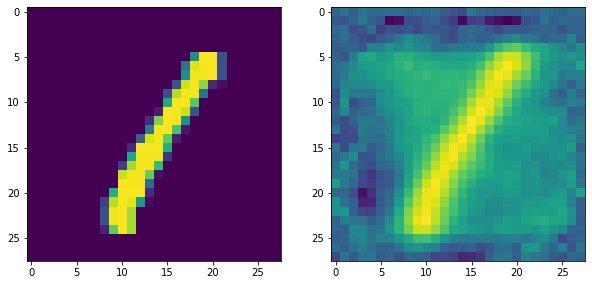

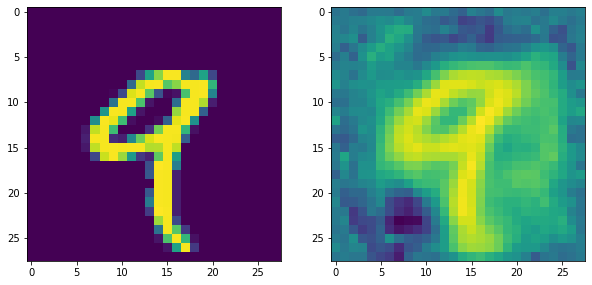

In [69]:
samples = x_train[1:5]

for sample in samples:
  vae_show_results(vae, sample)

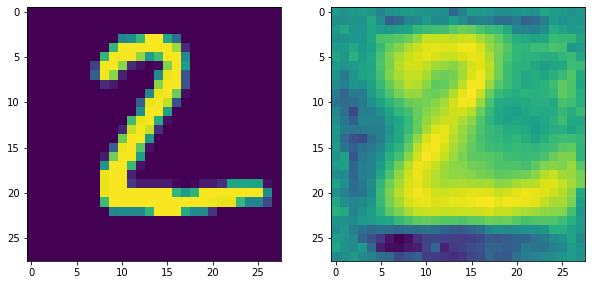

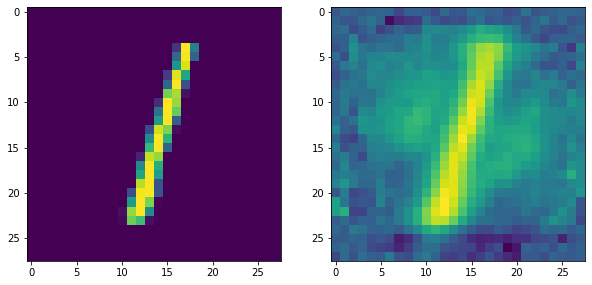

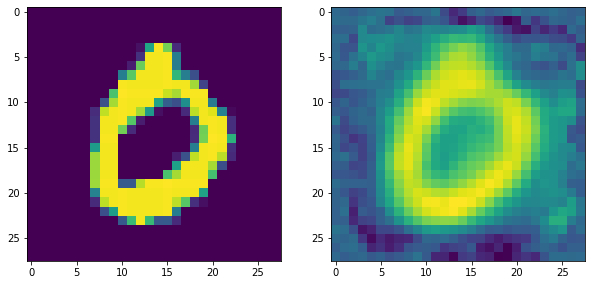

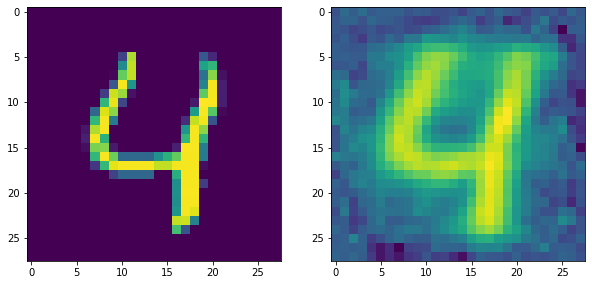

In [70]:
samples = x_test[1:5]

for sample in samples:
  vae_show_results(vae, sample)

What if we try to generate some data?

<tf.Tensor: shape=(5, 1, 28, 28), dtype=float32, numpy=
array([[[[-3.849486 , -3.5599935, -3.5075796, ..., -3.510112 ,
          -3.4279313, -3.1632657],
         [-3.1561499, -3.4098897, -3.2888148, ..., -3.438064 ,
          -3.0670574, -3.532714 ],
         [-3.2410092, -3.528885 , -3.6297832, ..., -4.759105 ,
          -3.5437834, -3.2893398],
         ...,
         [-3.690052 , -2.6568828, -2.604946 , ..., -2.967454 ,
          -3.0172045, -3.312032 ],
         [-3.4855032, -3.377213 , -2.8003557, ..., -3.068364 ,
          -3.9097135, -3.370425 ],
         [-3.2612276, -3.1477346, -3.2871976, ..., -3.3574424,
          -3.5899062, -3.1903746]]],


       [[[-2.6248436, -2.5636601, -2.375562 , ..., -2.284046 ,
          -2.0492709, -2.4020643],
         [-2.5170252, -2.5938973, -2.3737783, ..., -2.5551527,
          -2.4790707, -2.372545 ],
         [-2.3353243, -2.466144 , -2.018389 , ..., -2.6543827,
          -2.4913619, -2.5345323],
         ...,
         [-2.261422 , -2.13558

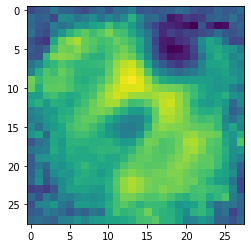

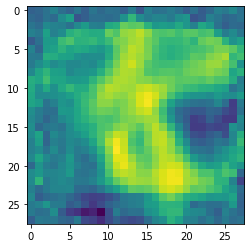

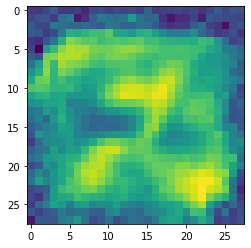

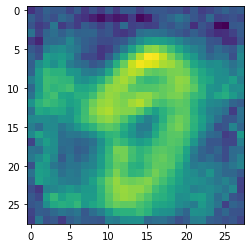

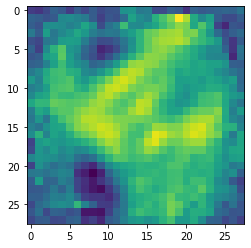

In [71]:
def vae_show_generated(generated):

  for image in generated:
    plt.figure();
    plt.imshow(image[0])

def vae_generate(vae, n, K):
  samples = np.random.normal(0, 1, size=(n, K))
  return vae.decode(samples)

generated_data = vae_generate(vae, 5, 40)
vae_show_generated(generated_data)
generated_data